# Loan Data from Prosper
# by Ailing Liu

## Investigation Overview

This project is reasearching on the possible features that affect the borrower’s APR or interest rate.

The Prosper Score is expected to have negative relation with ARP, because higher rating reflects borrower's good credit history or lower risk. When borrower has strong credibility, the interest rate is low. Additionally, other factors such as borrower's occupation, origional load amount, contract term, monthly income may also affect their APR.

## Dataset Overview

This data set is downloaded from Udacity. Originally it was from Prosper, America’s first marketplace lending platform, with over $9 billion in funded loans. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import urllib
%matplotlib inline
import os

In [2]:
df = pd.read_csv('DATA\prosperLoadData.csv')

In [3]:
#subset dataframe by selecting features of interests

cols = ['BorrowerAPR', 'ProsperScore', 'DelinquenciesLast7Years','StatedMonthlyIncome', 
        'AvailableBankcardCredit', 'CreditScoreRangeUpper', 'LoanOriginalAmount', 
        'Term', 'ProsperRating (Alpha)', 'EmploymentStatus', 'Occupation', 'LoanStatus']

loan = df[cols]

## Univariate Exploration

- main variable of interest: borrower APR

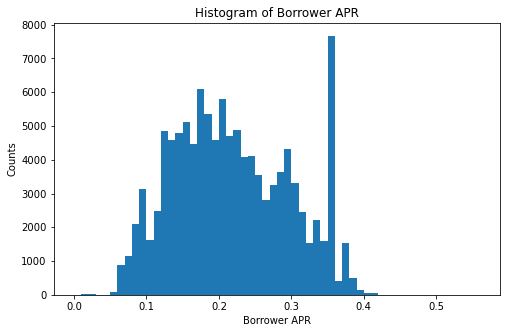

In [5]:
bins = np.arange(0, loan.BorrowerAPR.max()+0.05, 0.01)
plt.figure(figsize=(8, 5))
plt.hist(data = loan, x = 'BorrowerAPR', bins = bins);
plt.xlabel('Borrower APR')
plt.title('Histogram of Borrower APR')
plt.ylabel('Counts');

The distribution of APR looks normal except for a starggering peak round 0.35 to 0.37. A large peak centered at 0.2. Only very few loans have APR greater than 0.43.

- Prosper Score

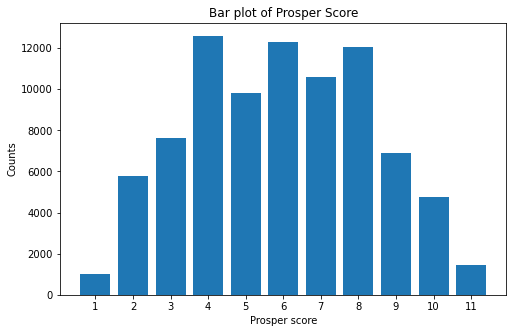

In [6]:
arr = loan['ProsperScore'].value_counts(sort=False)
plt.figure(figsize=(8, 5))
plt.bar(arr.index, arr.values)
plt.xticks(range(1, 12), range(1,12))
plt.xlabel('Prosper score')
plt.title('Bar plot of Prosper Score')
plt.ylabel('Counts');

Majority of the prosper scores range from 4 to 8. In particular, the most popular scores are 4, 6, 8. 

- Occupation

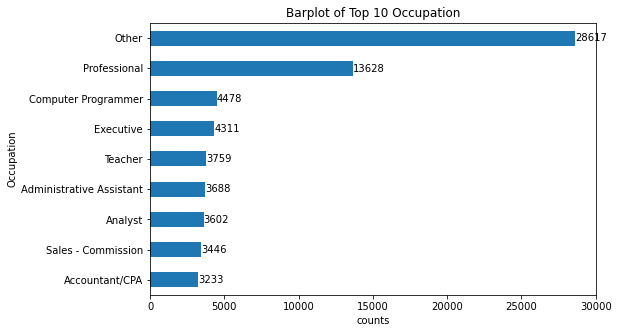

In [7]:
arr = loan['Occupation'].value_counts(ascending=True)[-9:]
arr.plot(kind='barh', figsize=(8, 5))
for i, v in enumerate(arr):
    plt.text(v+0.1, i-0.1, str(v))
plt.xlabel('counts')
plt.ylabel('Occupation')
plt.title('Barplot of Top 10 Occupation');

The top 2 occupation categories are "others" or "professional". These might be entered when people do not want to reveal their occupation. Other categories do not show a significant spike in the proportion.

* Monthly Income

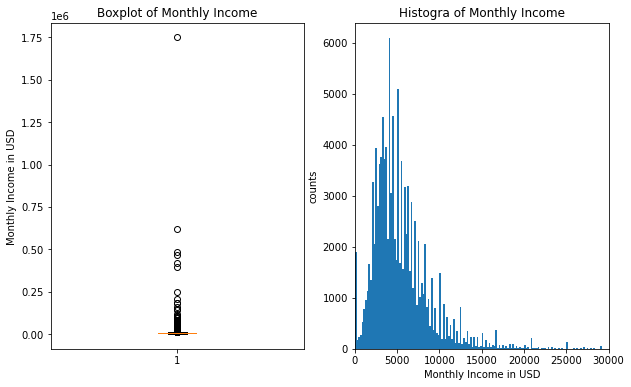

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.boxplot(loan['StatedMonthlyIncome'])
ax1.set(title='Boxplot of Monthly Income', ylabel='Monthly Income in USD', xlabel=None)
bins=np.arange(0, loan['StatedMonthlyIncome'].max()+10, 200)
ax2.hist(data=loan, x='StatedMonthlyIncome', bins=bins)
ax2.set(title='Histogra of Monthly Income', ylabel='counts', xlabel='Monthly Income in USD')
plt.xlim([0, 30000]);

The distribution of stated monthly income is highly screwed to the right, with most of stated monthly income less than 25k. A large number of outliers are seen in the upper range.

In [9]:
# exclude the strange rich people who borrow very little amount
mask = (loan['StatedMonthlyIncome']< 30000)
loan = loan[mask]

## Bivariate Exploration

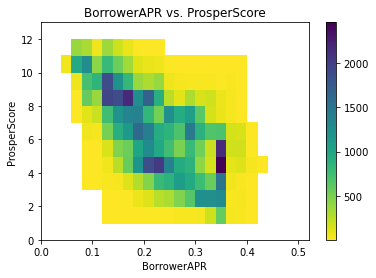

In [23]:
bins_x = np.arange(0, loan['BorrowerAPR'].max()+0.01, 0.02)
bins_y = np.arange(0, loan['ProsperScore'].max()+3, 1)
plt.hist2d(data = loan, x = 'BorrowerAPR', y = 'ProsperScore', bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 0.3)
plt.colorbar()
plt.title('BorrowerAPR vs. ProsperScore')
plt.xlabel('BorrowerAPR')
plt.ylabel('ProsperScore')
plt.show();

The largest correlation pair is the borrower APR and prosper score, with negative correlation coefficient of -0.668. It matches our assumption that the higher the prosper score, the lower risk the candidate, hence the lower interest rate. The scatter plot showed those two variables are negatively correlated.

## Multivariate Exploration

* Borrower APR across rating and term

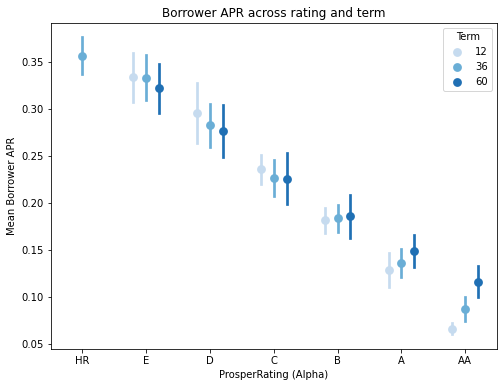

In [12]:
fig = plt.figure(figsize = (8,6))
ax = sb.pointplot(data = loan, x = 'ProsperRating (Alpha)', y = 'BorrowerAPR', hue = 'Term',
           palette = 'Blues', linestyles = '', dodge = 0.4, ci='sd', order=['HR', 'E', 'D', 'C', 'B', 'A', 'AA'])
plt.title('Borrower APR across rating and term')
plt.ylabel('Mean Borrower APR')
ax.set_yticklabels([],minor = True);

Above point plot shows borrower APR perentage decrease along with the increase of prosper rating (AA is the largest rating). 

Within each rating, we can see three vertical lines, representing three term durations. From rating HR to C, the three vertical lines are going downward in each rating, but from B to AA, the trend becomes upward. For people with high prosper rating range (B to AA), the longer contract they take, the higher APR percentage they will receive. For people with low prosper rating range (HR to C), the longer contract they sign up, the lower ARP rate they will receive.

* Loan Status by Occupation and Income

We first group the loan status into 'Non-Performing', i.e. defaulted, chargedoff loan, and 'Performing' group.
After that, we check the Non-Performing (NPF) rate by occupation and its average income.

In [13]:
non_performing_mask = loan['LoanStatus'].isin(['Defaulted', 'Chargedoff'])
non_perf = loan[non_performing_mask].groupby('Occupation')['LoanStatus'].size().to_frame('NPF_Counts')
perf = loan[~non_performing_mask].groupby('Occupation')['LoanStatus'].size().to_frame('PF_Counts')
income = loan.groupby('Occupation')['StatedMonthlyIncome'].mean().to_frame('Mean_Income')

occupation_loan_status = non_perf.join(perf, how='outer', lsuffix='_NonPerf', rsuffix='_Perf')\
.join(income, how='outer').fillna(0)
occupation_loan_status['Total'] =  occupation_loan_status['NPF_Counts']+occupation_loan_status['PF_Counts']
occupation_loan_status['NPF%'] = occupation_loan_status['NPF_Counts'] / occupation_loan_status['Total']

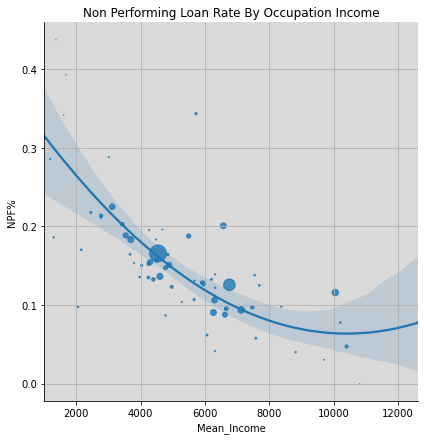

In [29]:
sb.lmplot(x="Mean_Income", y="NPF%", order=2, scatter_kws={'s':occupation_loan_status['Total']/100}, height=6, data=occupation_loan_status)
plt.title('Non Performing Loan Rate By Occupation Income')
plt.grid(True)
ax=plt.gca()
ax.set_facecolor([0.85, 0.85, 0.85]);

Above plot shows the relationship among Non-Performing loans % vs. Mean Income by profession and include a best-fit plot with second order. We can see that borrowers in lower-income Occupations generally have a higher percentage of non-performing loans. This trend makes sense because occupations with higher incomes have more stability to pay back their loans. The size of the circles indicates the number of cases falling into this coordinate. We can see that main group have salary about $4200, and their non-performing rate is about 18%.